In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
import galsim_compare_tools as gct

In [2]:
%pylab inline
# Setup: declaring survey properties, loading catalog and making sure we have pretty colorbars
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, WFIRST, HSC, RUBIN = gct.load_surveys()

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

mymap = 'gnuplot2'#mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


CPU times: user 22.2 ms, sys: 3.74 ms, total: 26 ms
Wall time: 16.8 ms
Galsim timing
CPU times: user 62 ms, sys: 11.4 ms, total: 73.4 ms
Wall time: 12.4 ms
scarlet SDR:  78.21883919593489
galsim SDR:  14.348576488127797


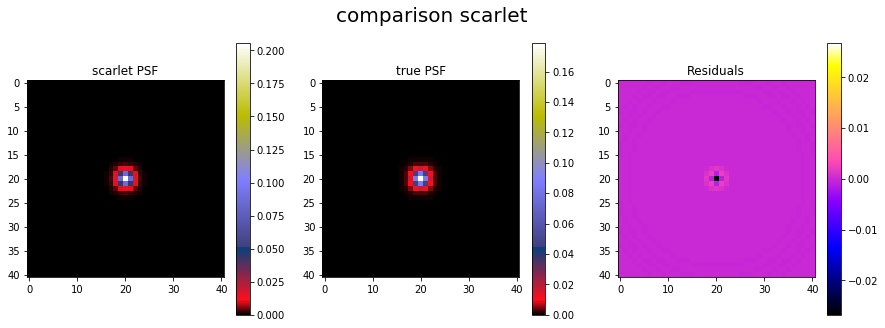

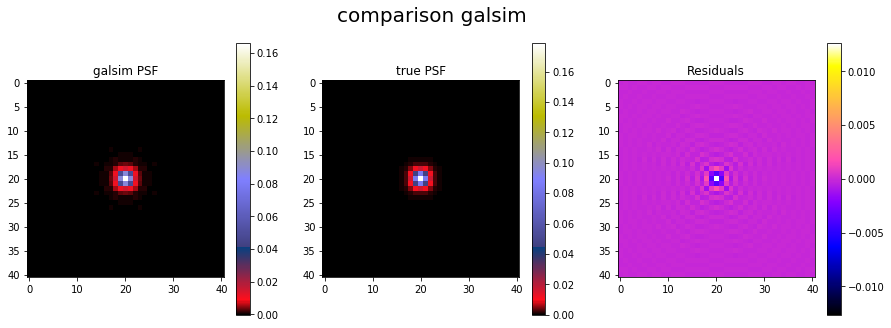

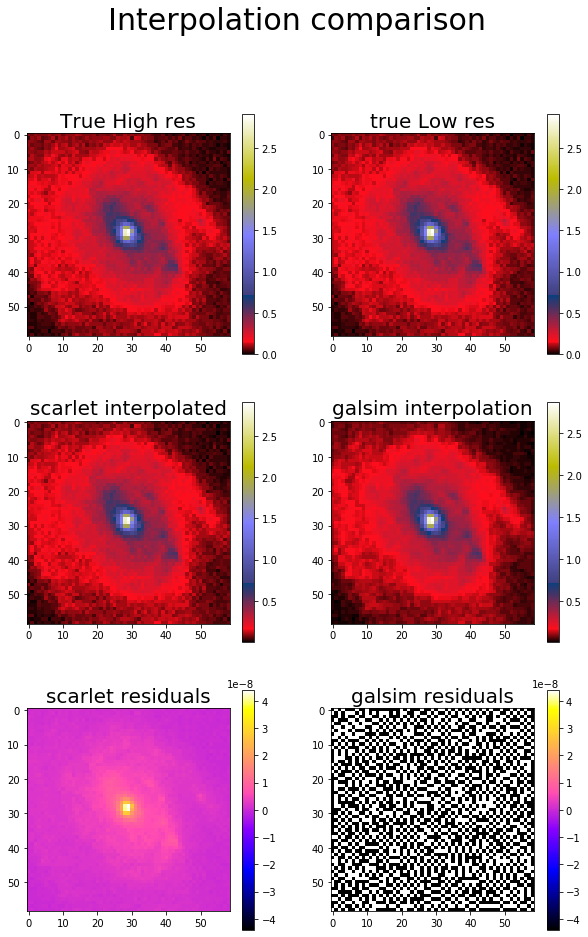

CPU times: user 45.4 ms, sys: 11.9 ms, total: 57.3 ms
Wall time: 25.7 ms
Galsim timing
CPU times: user 58.5 ms, sys: 10.5 ms, total: 69 ms
Wall time: 11.6 ms
scarlet SDR:  78.19304757957785
galsim SDR:  7.3801842318788236


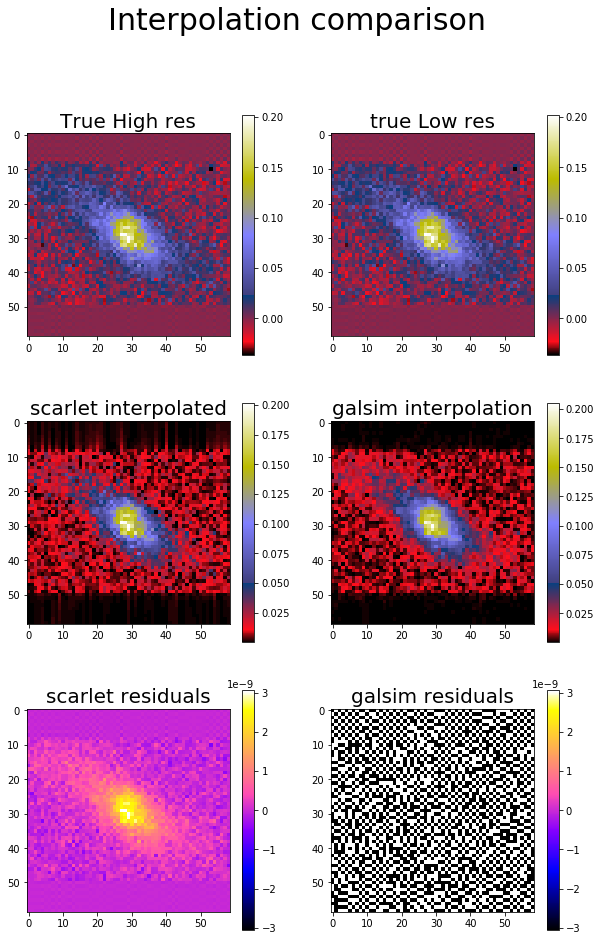

CPU times: user 49.6 ms, sys: 13.9 ms, total: 63.5 ms
Wall time: 28.8 ms
Galsim timing
CPU times: user 39.6 ms, sys: 6.74 ms, total: 46.3 ms
Wall time: 7.87 ms
scarlet SDR:  78.29034558314416
galsim SDR:  11.782840554174822


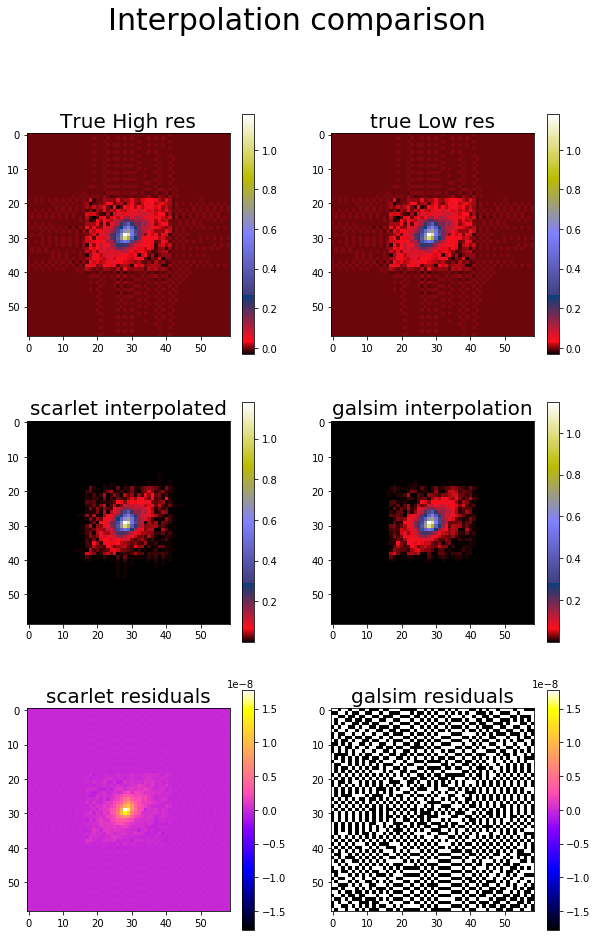

CPU times: user 46.9 ms, sys: 12.7 ms, total: 59.5 ms
Wall time: 26.9 ms
Galsim timing
CPU times: user 45.6 ms, sys: 7.73 ms, total: 53.3 ms
Wall time: 9.01 ms
scarlet SDR:  78.17903549766721
galsim SDR:  6.743101132523998


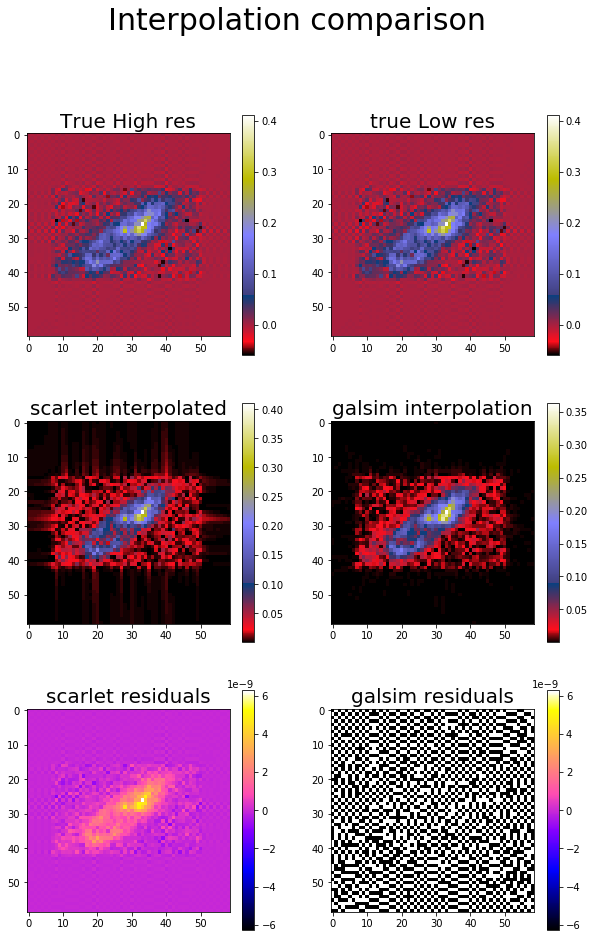

CPU times: user 50.5 ms, sys: 14.3 ms, total: 64.9 ms
Wall time: 29.3 ms
Galsim timing
CPU times: user 50.6 ms, sys: 9.31 ms, total: 59.9 ms
Wall time: 10.2 ms
scarlet SDR:  78.26156571442509
galsim SDR:  10.513674002677174


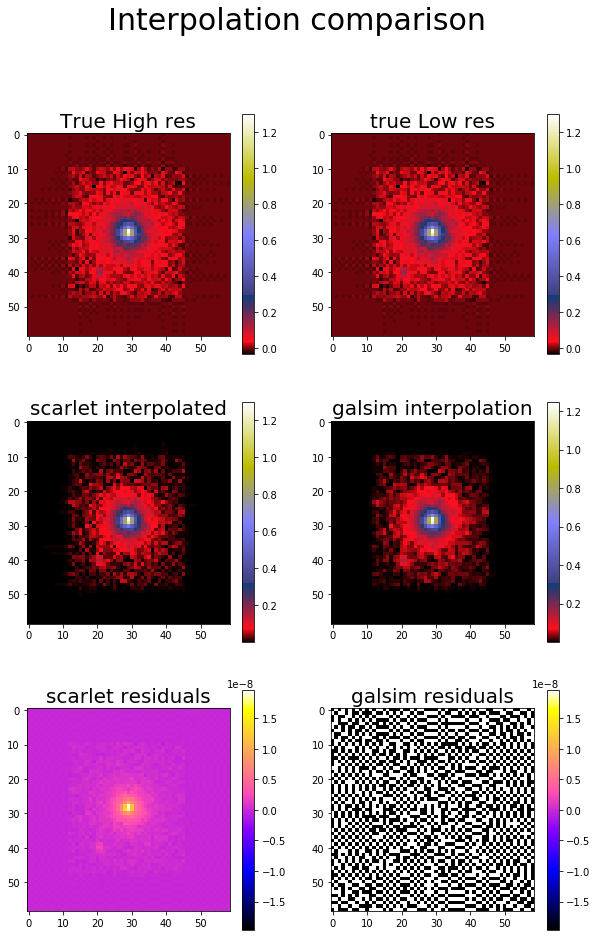

CPU times: user 50.2 ms, sys: 14.9 ms, total: 65 ms
Wall time: 29.7 ms
Galsim timing
CPU times: user 50.4 ms, sys: 18.4 ms, total: 68.8 ms
Wall time: 12.7 ms
scarlet SDR:  78.15978785276613
galsim SDR:  3.504043310298349


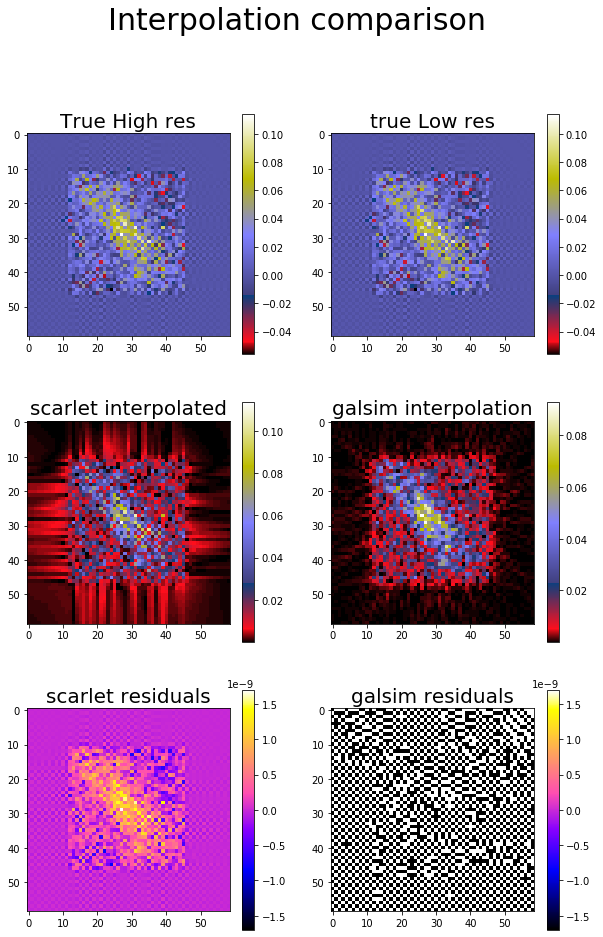

CPU times: user 47.3 ms, sys: 13.3 ms, total: 60.7 ms
Wall time: 27.6 ms
Galsim timing
CPU times: user 52.6 ms, sys: 8.4 ms, total: 61 ms
Wall time: 10.3 ms
scarlet SDR:  78.32044787086197
galsim SDR:  12.64717927240866


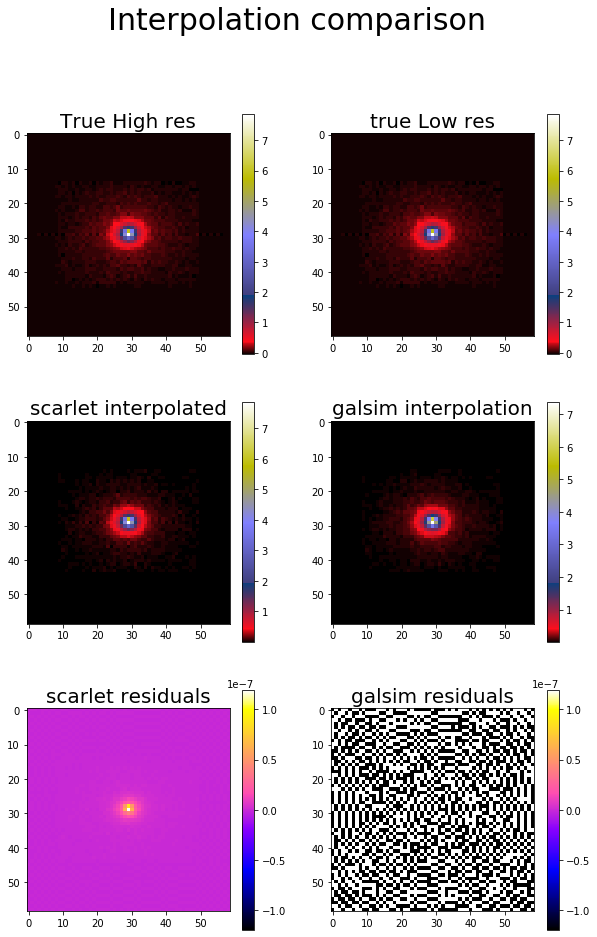

CPU times: user 56.1 ms, sys: 17.6 ms, total: 73.7 ms
Wall time: 33.3 ms
Galsim timing
CPU times: user 56.4 ms, sys: 19.6 ms, total: 76 ms
Wall time: 14.2 ms
scarlet SDR:  78.21184010808234
galsim SDR:  8.565285336909934


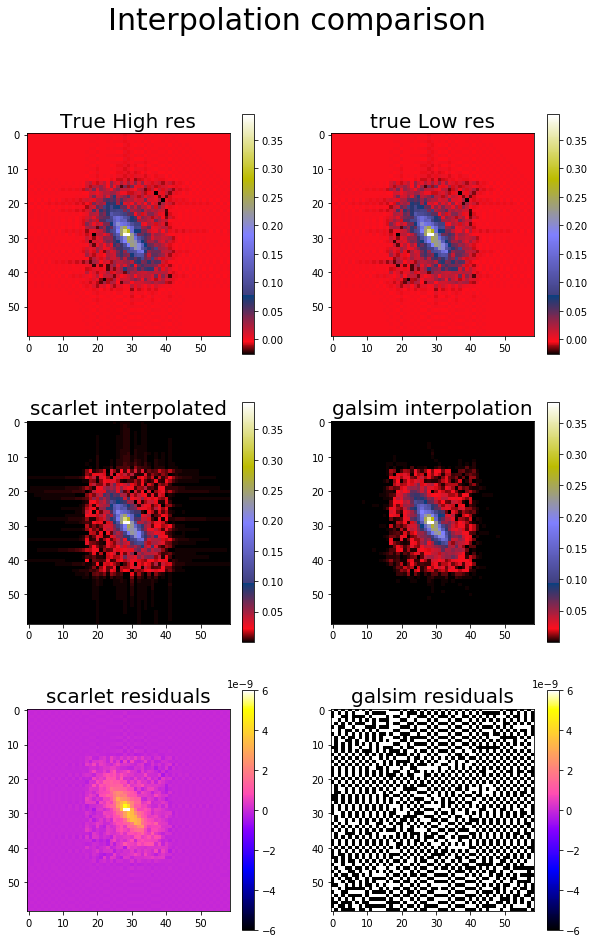

CPU times: user 55.4 ms, sys: 19.7 ms, total: 75.1 ms
Wall time: 34.2 ms
Galsim timing
CPU times: user 15.2 ms, sys: 32.8 ms, total: 48 ms
Wall time: 11.1 ms
scarlet SDR:  78.18221877213401
galsim SDR:  11.433097345674065


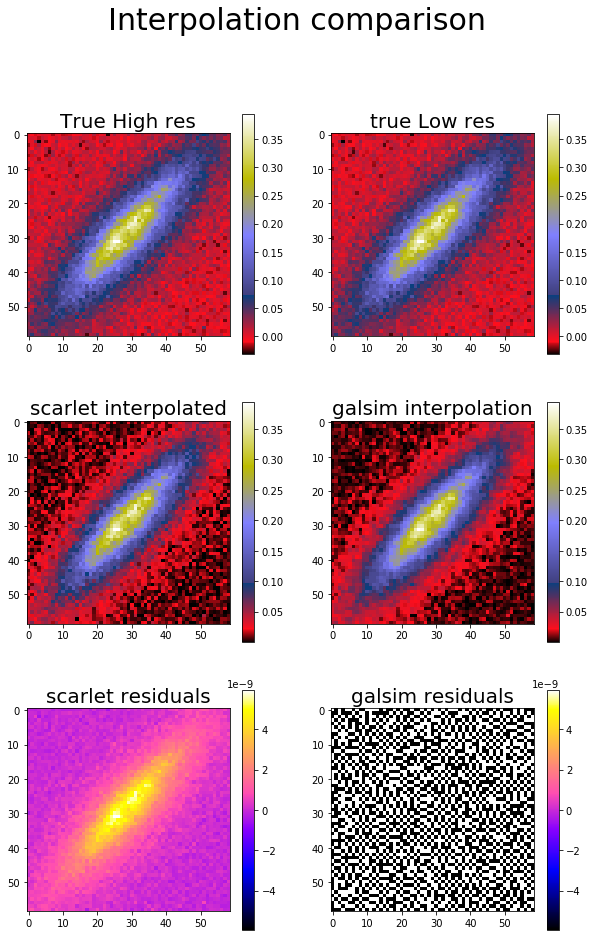

CPU times: user 50.2 ms, sys: 14.6 ms, total: 64.8 ms
Wall time: 29.8 ms
Galsim timing
CPU times: user 39.8 ms, sys: 6.99 ms, total: 46.8 ms
Wall time: 7.86 ms
scarlet SDR:  78.24275376989364
galsim SDR:  12.14824120381305


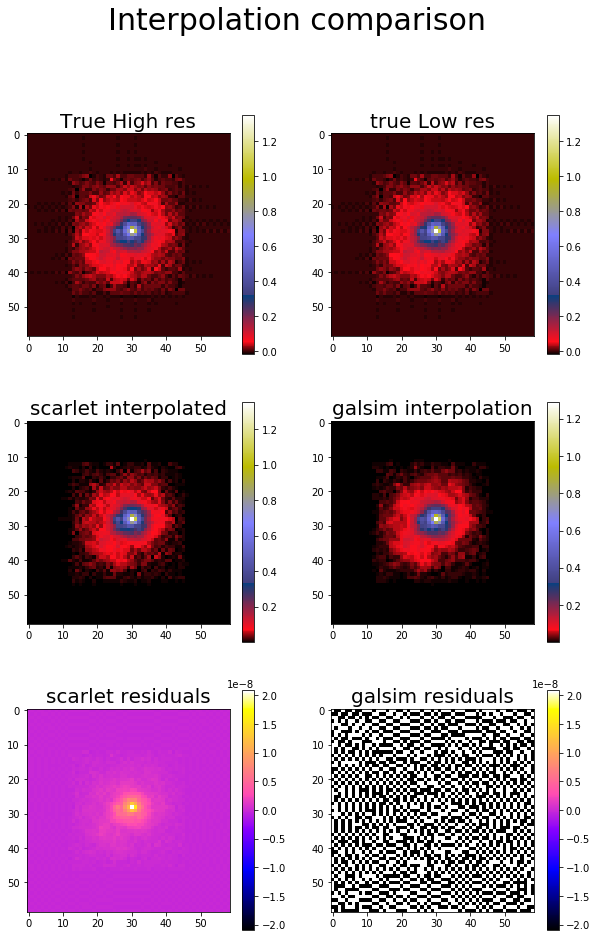

CPU times: user 48.2 ms, sys: 13.4 ms, total: 61.6 ms
Wall time: 27.4 ms
Galsim timing
CPU times: user 54.6 ms, sys: 9.7 ms, total: 64.3 ms
Wall time: 10.9 ms
scarlet SDR:  78.22538789078668
galsim SDR:  11.115146696771113


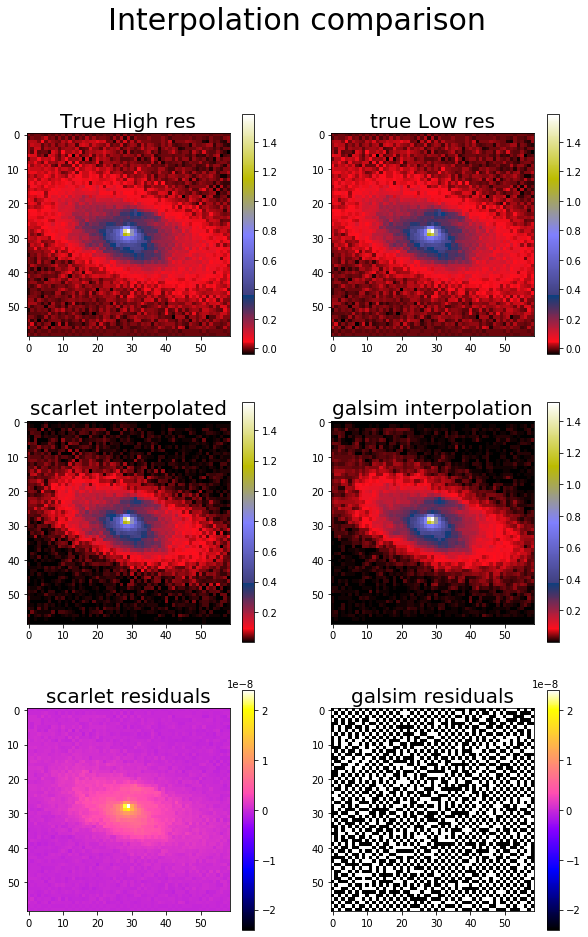

In [3]:
# Choose to surveys to match
survey_hr = HST
survey_lr = HST

# PSF size (pixels)
npsf = 41

# Size of the high resolution image (pixels)
n_hr = 59

# The low resolution image will span the same physical area
n_lr = np.around(n_hr*survey_hr['pixel']/survey_lr['pixel'])

# Channel names (scarlet-specific)
channel_hr = ['hr']
channel_lr = ['lr']
channels = channel_lr+channel_hr
c = 0
for i in range(39,50):    #[79,88]:#
    # Make the simulations
    data_hr, data_lr, psf_hr, psf_lr, angle = gct.mk_sim(i, survey_hr, survey_lr, (n_hr, n_hr), (n_lr, n_lr), npsf, cat)
    
    # Setup scarlet
    if c == 0:
        obs_lr, obs_hr = gct.setup_scarlet(data_hr, data_lr, psf_hr, psf_lr, channels, 'intersection')

    # Galsim setup:
    ## Interpolated image from psf_hr for galsim
    psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = survey_hr['pixel'])
    ## Deconvolution kernel for diff kernel
    deconv = galsim.Deconvolve(psf_hr_galsim)
    
    ## Interpolation of low resolution psf at high resolution from galsim
    psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = survey_lr['pixel'])
    ## Difference kernel from galsim
    diff_gal = galsim.Convolve(deconv, psf_lr_hr)
    
    # Run scarlet on simulations:
    %time obs_lr.render(data_hr.array[None,:,:])
    interp_scar = obs_lr.render(data_hr.array[None,:,:])
    #interp_scar[interp_scar<0] = 0

    # Difference kernel from scarlet (for sanity checks)
    diff_scar = obs_lr.diff_psf
    
    # Run galsim on simlations
    print('Galsim timing')
    %time  gct.interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    interp_gal = gct.interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    
    # Check on the reconstruction of the PSF
    ## Reconstruction of the low resolution psf by galsim from hr psf and diff kernel (sanity check)
    rec_gal = galsim.Convolve(diff_gal, psf_hr_galsim).drawImage(nx=npsf,ny=npsf, scale=survey_hr['pixel'])
    
    ## True psf
    gal_lr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                      scale=survey_lr['pixel']).drawImage(nx=npsf,ny=npsf,scale=survey_hr['pixel']
                                                                         , method = 'real_space')
    
    ## Reconstruction of the low resolution psf by SCARLET from hr psf and diff kernl (sanity check)
    rec_scar = scarlet.fft.convolve(scarlet.fft.Fourier(psf_hr[0]), scarlet.fft.Fourier(diff_scar.image[0]))
    
    if c == 0:
        # Comparisonbetween scarlet and galsim of the reconstruction of the low resolution PSF at high resolution 
        r_scar=(gal_lr.array-rec_scar.image)
        figure(figsize = (15,5))
        plt.suptitle('comparison scarlet', fontsize = 20)
        subplot(131)
        title('scarlet PSF')
        imshow((rec_scar.image))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_scar), cmap = mymap, 
               vmin = -np.max(np.abs(r_scar)), vmax = np.max(np.abs(r_scar)))
        plt.colorbar()

        r_gal = (gal_lr.array-rec_gal.array)
        figure(figsize = (15,5))
        plt.suptitle('comparison galsim', fontsize = 20)
        subplot(131)
        title('galsim PSF')
        imshow((rec_gal.array))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_gal), cmap = mymap, 
               vmin = -np.max(np.max(r_gal)), vmax = np.max(np.max(r_gal)))
        plt.colorbar()
    
    # Source Distortion Ratio: the high the better
    print('scarlet SDR: ', gct.SDR(data_lr.array, interp_scar[0]))
    print('galsim SDR: ', gct.SDR(data_lr.array, interp_gal.array))
    
    # Comparison of the reconstructions 
    gal_res = data_lr.array-interp_gal.array
    scar_res = data_lr.array-interp_scar[0]
    figure(figsize = (10,15))
    plt.suptitle('Interpolation comparison', fontsize=30)
    subplot(321)
    title('True High res', fontsize = 20)
    imshow((data_hr.array))
    plt.colorbar()
    subplot(322)
    title('true Low res', fontsize = 20)
    imshow((data_lr.array))
    plt.colorbar()
    subplot(323)
    title('scarlet interpolated', fontsize = 20)
    imshow(np.abs(interp_scar[0]))
    plt.colorbar()
    subplot(324)
    title('galsim interpolation', fontsize = 20)
    imshow(np.abs(interp_gal.array))
    plt.colorbar()
    subplot(325)
    title('scarlet residuals', fontsize = 20)
    imshow(-(scar_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    subplot(326)
    title('galsim residuals', fontsize = 20)
    imshow(-(gal_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    show()
    
    c+=1
